In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from functools import partial
%matplotlib inline
plt.style.use('ggplot')

## 1 Loading data

In [2]:
data_train = pd.read_csv('train.csv')
data_test  = pd.read_csv('test.csv')
data_full  = pd.concat([data_train,data_test],ignore_index=True)

## 2 Feature enginering

### Names

In [3]:
data_full['Title'] = data_full['Name'].apply(partial(re.sub,'(.*, )|(\\..*)',''))

In [4]:
rare_title = ['Dona', 'Lady', 'the Countess','Capt', 'Col', 'Don', 
              'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer']
data_full.Title = data_full.Title.apply(lambda x: 'Miss' if x == 'Mlle' else x)
data_full.Title = data_full.Title.apply(lambda x: 'Miss' if x == 'Ms' else x)
data_full.Title = data_full.Title.apply(lambda x: 'Mrs'  if x == 'Mme' else x)
data_full.Title = data_full.Title.apply(lambda x: 'Rare Title' if x in rare_title else x)

In [5]:
# It is table in R
data_full.groupby('Sex')['Title'].value_counts().unstack().fillna(0).astype(np.uint8)

Title,Master,Miss,Mr,Mrs,Rare Title
Sex,,,,,
female,0,8,0,198,4
male,61,0,245,0,25


In [6]:
pd.crosstab(data_full.Sex,data_full.Title)

Title,Master,Miss,Mr,Mrs,Rare Title
Sex,,,,,
female,0,264,0,198,4
male,61,0,757,0,25


In [7]:
# Grabing surnmaes
data_full['Surname'] = data_full['Name'].apply(lambda x:  
                                               x.split(sep=',')[0].strip().split()[0].strip())

### Families

In [8]:
# Family size
data_full['Fsize'] = data_full.SibSp + data_full.Parch + 1

In [9]:
# Family variable
data_full['Family'] = data_full.Surname +pd.Series('_',index=data_full.index)+ data_full.Fsize.apply(str)

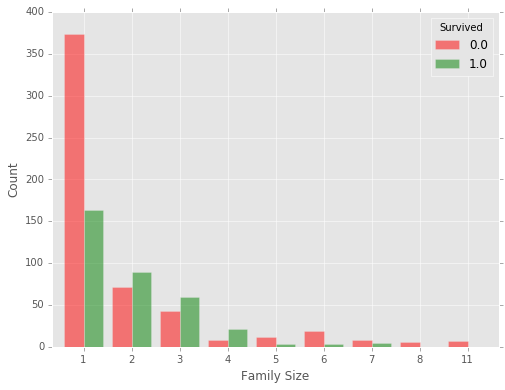

In [10]:
# Visualize

df=data_full[0:891].groupby('Fsize')['Survived'].value_counts().unstack()
df.plot.bar(figsize=(8,6),width = 0.8,color = ['r','g'],alpha=0.5)
plt.ylabel('Count'); plt.xlabel('Family Size')
plt.xticks(rotation = 'horizontal');

In [11]:
def Discretize_Fsize(size):
    if size == 1: return 'singleton'
    elif (size < 5) and (size > 1) : return 'small'
    else: return 'large'

In [12]:
data_full['FsizeD'] = data_full.Fsize.apply(Discretize_Fsize)

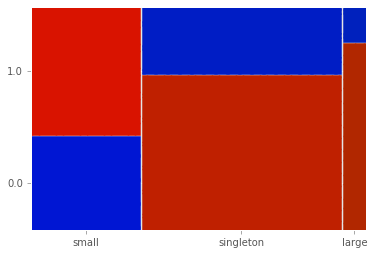

In [13]:
# Visualize
from statsmodels.graphics.mosaicplot import mosaic
df = data_full[0:890]
#df = pd.crosstab(df.Sex,df.Title)
mosaic(df,['FsizeD','Survived'],labelizer=lambda x: '',statistic=True);

### Cabin

In [14]:
data_full.Cabin = data_full.Cabin.astype(str)

In [15]:
data_full['Deck'] = data_full.Cabin.apply(lambda x: x[0] if x != 'nan' else '')

## Missing values

### Embarked

In [16]:
any(data_full.Embarked.isnull())

True

In [17]:
data_full[data_full.Embarked.isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Surname,Fsize,Family,FsizeD,Deck
61,38,B28,NaN,80,"Icard, Miss. Amelie",0,62,1,female,0,1,113572,Miss,Icard,1,Icard_1,singleton,B
829,62,B28,NaN,80,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1,113572,Mrs,Stone,1,Stone_1,singleton,B


In [29]:
df=data_full[-data_full.Embarked.isnull()].groupby('Embarked')[['Fare','Pclass']]
df.groups.keys()

dict_keys(['Q', 'S', 'C'])

In [31]:
df1 = df.get_group('S').pivot(columns='Pclass')['Fare']
df2 = df.get_group('C').pivot(columns='Pclass')['Fare']
df3 = df.get_group('Q').pivot(columns='Pclass')['Fare']

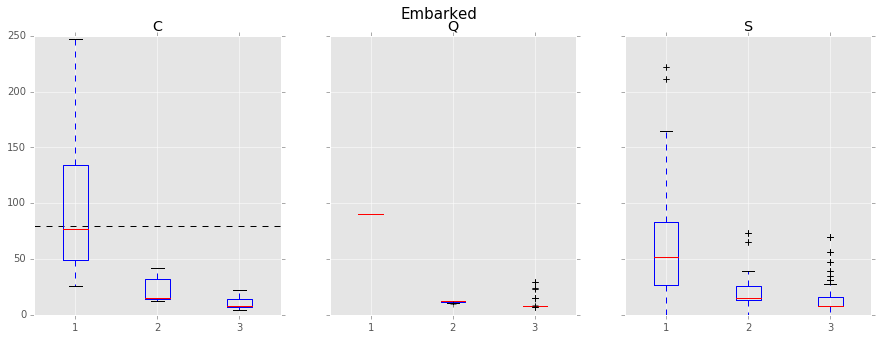

In [33]:
fig, axs = plt.subplots(nrows=1,ncols=3,sharey=True)
fig.set_size_inches(15,5)
fig.suptitle('Embarked',size=15)

df1.boxplot(return_type='dict',ax=axs[2])
df2.boxplot(return_type='dict',ax=axs[0])
df3.boxplot(return_type='dict',ax=axs[1])
axs[0].set_title('C')
axs[1].set_title('Q')
axs[2].set_title('S')
ax=axs[0]
axs[0].hlines(y=80,xmin=ax.set_xlim()[0],xmax=ax.set_xlim()[1], linestyles =['dashed'])
plt.ylim(0,250);

In [34]:
# Setting Emarked for missing to 'C'
data_full.loc[61,'Embarked']='C'
data_full.loc[829,'Embarked']='C'

### Fare

In [35]:
data_full[data_full.Fare.isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Surname,Fsize,Family,FsizeD,Deck
1043,60.5,nan,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701,Mr,Storey,1,Storey_1,singleton,


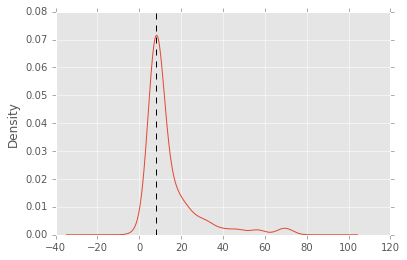

In [36]:
# Let's have a look at people with Pclass = 3 & Embarked = 'S'
df = data_full[(data_full.Embarked == 'S') & (data_full.Pclass == 3)]
df.Fare.plot.kde()
#xmin = plt.gca().set_xlim()[0]

plt.vlines(x=df.Fare.median(),ymin=plt.gca().set_ylim()[0],ymax=plt.gca().set_ylim()[1],
          linestyles=['dashed']);

In [37]:
data_full.loc[1043,'Fare'] = df.Fare.median()

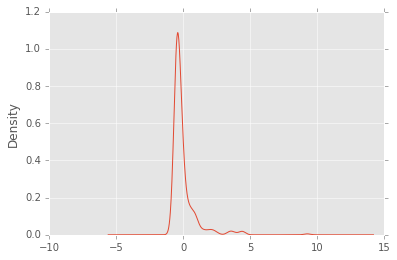

In [53]:
# Fare looks skewed. Let's normalzie it
from sklearn.preprocessing import scale
data_full['Fare'] = scale(data_full['Fare'].values)
data_full.Fare.plot.kde();

### Age

In [54]:
# Many missing values
print('Missing', data_full.Age.isnull().sum(), 'ages out of', len(data_full))

Missing 263 ages out of 1309


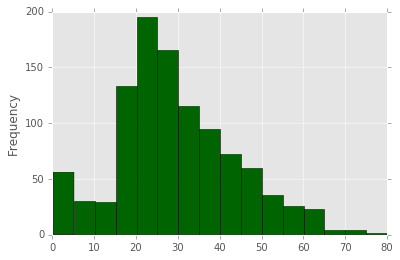

In [55]:
# Visualize existing ages
df = data_full.Age
df.plot.hist(bins = 16,color = 'darkgreen',edgecolor='k');

In [56]:
data = pd.read_table('mice_output',sep='\s+')

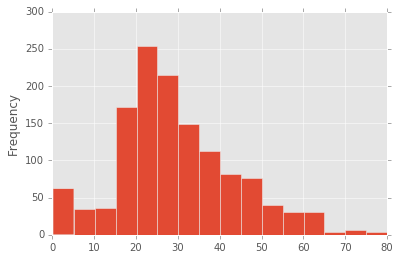

In [57]:
df = data.Age
df.plot.hist(bins=16);

In [58]:
data_full.Age = data.Age.values

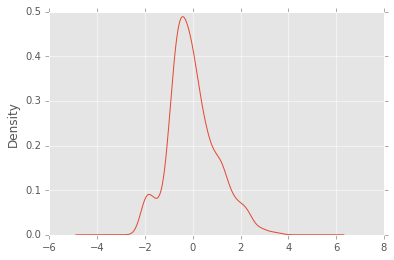

In [61]:
data_full.Age =scale(data_full.Age)
df = data_full.Age
df.plot.kde();

### Child and Mother

In [62]:
df = data_full.loc[0:890,['Sex','Age','Survived']].groupby('Sex')
dfM = df.get_group('male')[['Age','Survived']].pivot(columns='Survived')['Age']
dfF = df.get_group('female')[['Age','Survived']].pivot(columns='Survived')['Age']

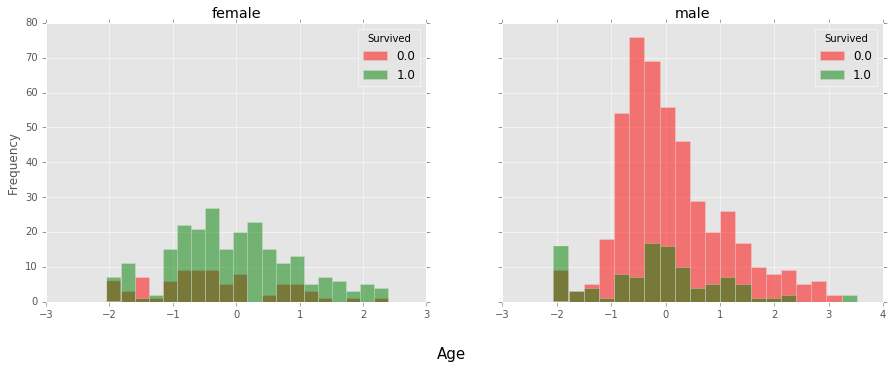

In [63]:
fig, axs = plt.subplots(nrows=1,ncols=2,sharey=True)
fig.set_size_inches(15,5)
fig.suptitle('Age',size=15,x=0.5,y=0)
dfF.plot.hist(bins=20,color=['red','green'],alpha=0.5,ax=axs[0])
dfM.plot.hist(bins=20,color=['red','green'],alpha=0.5,ax=axs[1])
axs[0].set_title('female')
axs[1].set_title('male');

In [64]:
def child(age):
    return 'child' if age < 18 else 'Adult'

In [65]:
# Adding new column
data_full['Child'] = data_full.Age.apply(child)

In [66]:
data_full['Mother'] = pd.Series('Not Mother', index=data_full.index)
data_full.loc[(data_full.Sex == 'female') & (data_full.Parch > 0) & (data_full.Age > 18) & (data_full.Title != 'Miss') 
              ,'Mother'] = 'Mother'

In [67]:
pd.crosstab(data_full.Mother,data_full.Survived)

Survived,0.0,1.0
Mother,,
Not Mother,549,342


## 3 Prediction

In [87]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn import metrics
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.decomposition import PCA

In [69]:
data_train = data_full[0:891]
data_test  = data_full[891:1309]

In [70]:
print(data_train.columns.values)

['Age' 'Cabin' 'Embarked' 'Fare' 'Name' 'Parch' 'PassengerId' 'Pclass'
 'Sex' 'SibSp' 'Survived' 'Ticket' 'Title' 'Surname' 'Fsize' 'Family'
 'FsizeD' 'Deck' 'Child' 'Mother']


In [136]:
features = ['Pclass', 'Sex', 'Age','Fsize','Fare', 'Title'] #, 'Child', 'Mother']

In [137]:
# Hashing features
X_feature =data_train[features]
y = data_train['Survived']

X_dict=X_feature.T.to_dict().values()

vect = DictVectorizer(sparse=False)
X_train = vect.fit_transform(X_dict)

#le = LabelEncoder()
y_train = y #le.fit_transform(y)

In [143]:
# RANDOM FOREST
def RF(y_train,X_train,n = 1000):
    clf_rf = RandomForestClassifier(n_estimators=n, criterion='gini',
                                    oob_score=True,n_jobs=-1)
    clf_rf.fit(X_train,y_train)

    Train_predict = clf_rf.predict(X_train)    

    print('Score on the original data:\n','\t', metrics.accuracy_score(y_train,Train_predict),'\n') 
    print('OOB score:\n\t',clf_rf.oob_score_)
    
    return clf_rf
#print('-------------------------------------')
#print('Report:\n', metrics.classification_report(y_train,Train_predict))

#n_folds = 3
#k_fold = cross_validation.KFold(len(X_train),n_folds=n_folds,shuffle=True)
#scores = cross_validation.cross_val_score(clf_rf,X_train,y_train,cv=k_fold)
#print('-------------------------------------')
#print('Score after cross validation:\n', '\t',scores.mean(),'+/-',scores.std(),'\n\n\t',scores)

In [144]:
clf = RF(y_train,X_train)

Score on the original data:
 	 0.985409652076 

OOB score:
	 0.810325476992


In [145]:
X_test = data_test[features]

X_dict=X_test.T.to_dict().values()

vect = DictVectorizer(sparse=False)
X_test = vect.fit_transform(X_dict)

y_predict = clf.predict(X_test)

In [146]:
y_predict.sum()/len(y_predict)

0.39952153110047844

In [147]:
submit_df = pd.DataFrame({'PassengerId': np.arange(892,1310), 'Survived': y_predict})
submit_df.to_csv("RF_SUB_20160708_1.csv",index=False)